In [1467]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [1468]:
train = pd.read_csv("train.csv", index_col="ID")
test = pd.read_csv("test.csv", index_col="ID")
# stag, industry, greywage, way, selfcontrol 부족

In [1469]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 1 to 699
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   stag          516 non-null    float64
 1   event         699 non-null    int64  
 2   gender        699 non-null    object 
 3   age           699 non-null    float64
 4   industry      672 non-null    object 
 5   profession    699 non-null    object 
 6   traffic       699 non-null    object 
 7   coach         699 non-null    object 
 8   head_gender   699 non-null    object 
 9   greywage      679 non-null    object 
 10  way           678 non-null    object 
 11  extraversion  699 non-null    float64
 12  independ      699 non-null    float64
 13  selfcontrol   666 non-null    float64
 14  anxiety       699 non-null    float64
 15  novator       699 non-null    float64
dtypes: float64(7), int64(1), object(8)
memory usage: 92.8+ KB


In [1470]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 430 entries, 700 to 1129
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   stag          321 non-null    float64
 1   gender        430 non-null    object 
 2   age           430 non-null    float64
 3   industry      430 non-null    object 
 4   profession    430 non-null    object 
 5   traffic       430 non-null    object 
 6   coach         430 non-null    object 
 7   head_gender   360 non-null    object 
 8   greywage      430 non-null    object 
 9   way           430 non-null    object 
 10  extraversion  430 non-null    float64
 11  independ      430 non-null    float64
 12  selfcontrol   385 non-null    float64
 13  anxiety       430 non-null    float64
 14  novator       430 non-null    float64
dtypes: float64(7), object(8)
memory usage: 53.8+ KB


In [1471]:
def concat_df(train, test):
    return pd.concat([train, test], sort=True).reset_index(drop=True)

In [1472]:
def divide_df(all_data):
    return all_data.loc[:698], all_data.loc[699:].drop(["event"], axis=1)

In [1473]:
df_train =  pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_all = concat_df(df_train, df_test)

In [1474]:
df_train.name = "Training Set"
df_test.name = "Test Set"
df_all.name = "All Set"

In [1475]:
dfs=[df_train, df_test]
df_all_corr = df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature1","level_1":"Feature2",0:"Correlation Coefficient"}, inplace=True)

In [1476]:
df_all_corr[df_all_corr["Feature1"]=="selfcontrol"]

,Feature1,Feature2,Correlation Coefficient
1,selfcontrol,selfcontrol,1.000000
9,selfcontrol,novator,0.554316
12,selfcontrol,extraversion,0.539005
26,selfcontrol,independ,0.174135
36,selfcontrol,anxiety,0.095258
37,selfcontrol,stag,0.083115
49,selfcontrol,event,0.049588
57,selfcontrol,age,0.028387
59,selfcontrol,ID,0.027986


In [1477]:
df_all['selfcontrol'] = df_all.groupby(['gender', 'novator'])['selfcontrol'].apply(lambda x: x.fillna(x.median()))

In [1478]:
df_all[df_all["industry"].isnull()]

,ID,age,anxiety,coach,event,extraversion,gender,greywage,head_gender,independ,industry,novator,profession,selfcontrol,stag,traffic,way
47,48,49.000000,5.6,my head,1.0,4.6,f,white,f,6.2,NaN,6.7,BusinessDevelopment,4.90,36.928131,empjs,bus
48,49,29.000000,4.0,yes,1.0,7.8,f,white,m,5.5,NaN,5.2,HR,5.70,3.975359,empjs,bus
49,50,29.000000,6.3,yes,1.0,6.2,f,white,m,6.2,NaN,2.9,HR,5.70,3.975359,empjs,bus
50,51,29.000000,4.0,yes,1.0,7.0,f,white,m,6.2,NaN,3.7,HR,5.70,3.975359,empjs,bus
51,52,36.000000,6.3,no,1.0,4.6,m,white,m,4.8,NaN,7.5,HR,7.20,7.589322,empjs,foot
52,53,22.000000,4.0,my head,1.0,8.6,f,white,m,4.8,NaN,6.7,Teaching,4.90,95.211499,advert,bus
53,54,21.000000,7.1,yes,1.0,7.8,f,white,f,5.5,NaN,9.0,HR,2.60,41.691992,empjs,foot
54,55,25.000000,6.3,no,1.0,8.6,f,white,f,6.2,NaN,6.0,HR,3.30,14.948665,empjs,bus
55,56,38.000000,6.3,no,1.0,6.2,m,white,m,3.4,NaN,3.7,HR,7.20,50.726899,rabrecNErab,car
56,57,38.000000,6.3,no,1.0,7.0,m,white,m,5.5,NaN,6.0,HR,5.70,50.726899,rabrecNErab,car


In [1479]:
is_event = df_all['event'] == 0

In [1480]:
(df_all[is_event]["industry"].value_counts()/df_all["industry"].value_counts())

 HoReCa            0.272727
Agriculture        0.200000
Banks              0.181818
Building           0.146341
Consult            0.094595
IT                 0.190083
Mining             0.043478
Pharma             0.250000
PowerGeneration    0.324324
RealEstate         0.333333
Retail             0.281139
State              0.211538
Telecom            0.222222
etc                0.200000
manufacture        0.204225
transport          0.378378
Name: industry, dtype: float64

In [1481]:
df_all["industry"] = df_all["industry"].fillna("Banks")

In [1482]:
dfs=[df_train, df_test]
df_all_corr = df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature1","level_1":"Feature2",0:"Correlation Coefficient"}, inplace=True)

In [1483]:
df_all["stag"].mean()

37.259146408851876

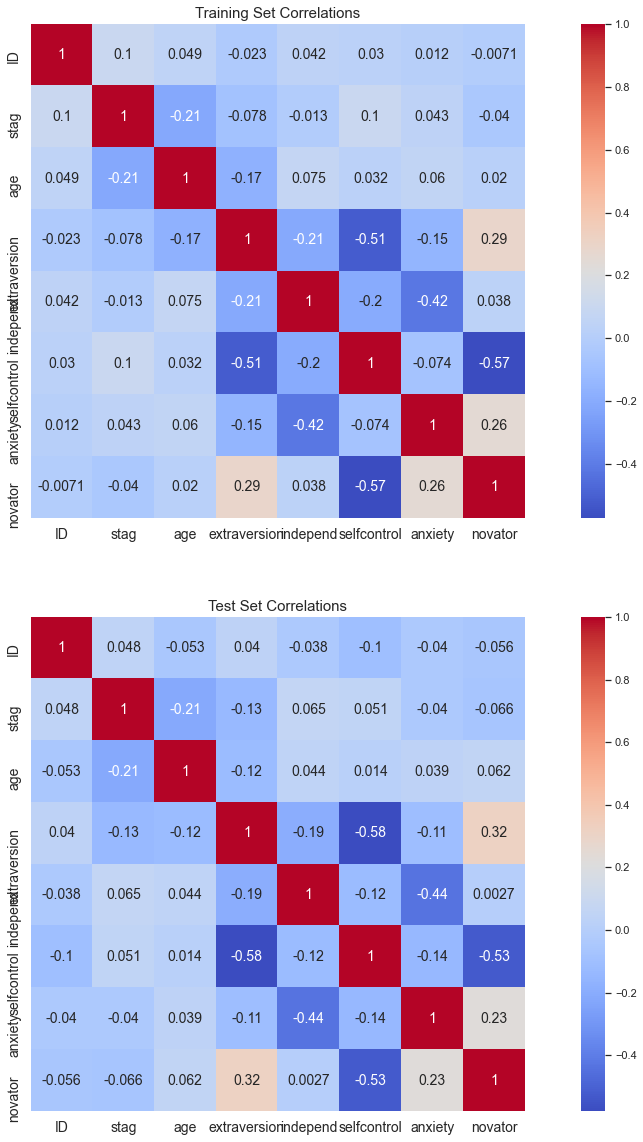

In [1484]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.heatmap(df_train.drop(["event"], axis=1).corr(), ax=axs[0], annot=True, square=True, cmap="coolwarm", annot_kws={"size":14})
sns.heatmap(df_test.corr(), ax=axs[1], annot=True, square=True, cmap="coolwarm", annot_kws={"size":14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

In [1485]:
df_all.groupby(["gender", "age"]).median()["stag"]

gender  age 
f       18.0    92.353183
        19.0    83.712526
        20.0    60.073922
        21.0    27.761807
        22.0    41.297741
                  ...    
m       48.0    12.517454
        49.0    21.158111
        51.0    25.659138
        52.0    22.078029
        54.0    15.605749
Name: stag, Length: 72, dtype: float64

In [1486]:
df_all['age'] = df_all['age'].astype('int64')

In [1487]:
index = df_all['age'][df_all['age'] == 47].index
index2 = df_all['age'][df_all['age'] == 58].index
df_all = df_all.drop(index)
df_all = df_all.drop(index2)

In [1488]:
pt = df_all.pivot_table(values="stag", index=["age"], aggfunc="mean")

In [1489]:
pt

,stag
age,
18,91.301848
19,110.869815
20,55.055441
21,46.242300
22,51.337507
23,49.376591
24,33.950719
25,43.169811
26,29.609136


In [1490]:
# 피봇테이블을 생성시 실수값이 굉장히 많아지잖아요 그래서 그 값이 근사값으로 묶여서 테이블이 형성되는과정속에서
# 47이라는 값이 없어졌습니다 피봇테이블보시면 한번 나이를 다 정수처리해서 테이블로 만들어보죠 여기도 똑같이 47이없네요
# 47 갯수가 굉장히 적나봐요

In [1491]:
pt2 = train.pivot_table(values="stag", index=["age"], aggfunc="mean")

In [1492]:
def fill_stag(df):
    if np.isnan(df["stag"]):
        return pt.loc[df["age"]]
    else:
        return df["stag"]

In [1493]:
df_all["stag"] = df_all.apply(fill_stag, axis=1).astype("int64")

In [1494]:
df_all["stag"]

0         7
1        22
2        15
3        15
4         8
       ... 
1124     10
1125     10
1126    118
1127     49
1128     24
Name: stag, Length: 1122, dtype: int64

In [1495]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122 entries, 0 to 1128
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            1122 non-null   int64  
 1   age           1122 non-null   int64  
 2   anxiety       1122 non-null   float64
 3   coach         1122 non-null   object 
 4   event         696 non-null    float64
 5   extraversion  1122 non-null   float64
 6   gender        1122 non-null   object 
 7   greywage      1102 non-null   object 
 8   head_gender   1053 non-null   object 
 9   independ      1122 non-null   float64
 10  industry      1122 non-null   object 
 11  novator       1122 non-null   float64
 12  profession    1122 non-null   object 
 13  selfcontrol   1122 non-null   float64
 14  stag          1122 non-null   int64  
 15  traffic       1122 non-null   object 
 16  way           1101 non-null   object 
dtypes: float64(6), int64(3), object(8)
memory usage: 157.8+ KB


In [1496]:
df_all["way"].value_counts()

bus     665
car     323
foot    113
Name: way, dtype: int64

In [1497]:
df_all["way"]= df_all["way"].fillna("bus")

In [1498]:
df_all["head_gender"].value_counts()

m    532
f    521
Name: head_gender, dtype: int64

In [1499]:
df_all["head_gender"]= df_all["head_gender"].fillna("m")

In [1500]:
df_all["greywage"].value_counts()

white    983
grey     119
Name: greywage, dtype: int64

In [1501]:
df_all["greywage"] = df_all["greywage"].fillna("white")

In [1502]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122 entries, 0 to 1128
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            1122 non-null   int64  
 1   age           1122 non-null   int64  
 2   anxiety       1122 non-null   float64
 3   coach         1122 non-null   object 
 4   event         696 non-null    float64
 5   extraversion  1122 non-null   float64
 6   gender        1122 non-null   object 
 7   greywage      1122 non-null   object 
 8   head_gender   1122 non-null   object 
 9   independ      1122 non-null   float64
 10  industry      1122 non-null   object 
 11  novator       1122 non-null   float64
 12  profession    1122 non-null   object 
 13  selfcontrol   1122 non-null   float64
 14  stag          1122 non-null   int64  
 15  traffic       1122 non-null   object 
 16  way           1122 non-null   object 
dtypes: float64(6), int64(3), object(8)
memory usage: 157.8+ KB


In [1503]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
ID column missing values: 0
stag column missing values: 183
event column missing values: 0
gender column missing values: 0
age column missing values: 0
industry column missing values: 27
profession column missing values: 0
traffic column missing values: 0
coach column missing values: 0
head_gender column missing values: 0
greywage column missing values: 20
way column missing values: 21
extraversion column missing values: 0
independ column missing values: 0
selfcontrol column missing values: 33
anxiety column missing values: 0
novator column missing values: 0


Test Set
ID column missing values: 0
stag column missing values: 109
gender column missing values: 0
age column missing values: 0
industry column missing values: 0
profession column missing values: 0
traffic column missing values: 0
coach column missing values: 0
head_gender column missing values: 70
greywage column missing values: 0
way column missing values: 0
extraversion column missing values: 0
independ column m

In [1504]:
df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

for df in dfs:
    display_missing(df)

ID column missing values: 0
age column missing values: 0
anxiety column missing values: 0
coach column missing values: 0
event column missing values: 0
extraversion column missing values: 0
gender column missing values: 0
greywage column missing values: 0
head_gender column missing values: 0
independ column missing values: 0
industry column missing values: 0
novator column missing values: 0
profession column missing values: 0
selfcontrol column missing values: 0
stag column missing values: 0
traffic column missing values: 0
way column missing values: 0


ID column missing values: 0
age column missing values: 0
anxiety column missing values: 0
coach column missing values: 0
extraversion column missing values: 0
gender column missing values: 0
greywage column missing values: 0
head_gender column missing values: 0
independ column missing values: 0
industry column missing values: 0
novator column missing values: 0
profession column missing values: 0
selfcontrol column missing values: 0
sta

In [1505]:
 df_train

,ID,age,anxiety,coach,event,extraversion,gender,greywage,head_gender,independ,industry,novator,profession,selfcontrol,stag,traffic,way
0,1,35,7.1,no,1.0,6.2,m,white,f,4.1,Banks,8.3,HR,5.7,7,rabrecNErab,bus
1,2,33,7.1,no,1.0,6.2,m,white,m,4.1,Banks,8.3,HR,5.7,22,empjs,bus
2,3,35,4.8,no,1.0,6.2,f,white,m,6.2,PowerGeneration,8.3,HR,2.6,15,rabrecNErab,bus
3,4,35,2.5,no,1.0,5.4,f,white,m,7.6,PowerGeneration,6.7,HR,4.9,15,rabrecNErab,bus
4,5,32,7.1,yes,1.0,3.0,m,white,f,4.1,Retail,3.7,Commercial,8.0,8,youjs,bus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,695,31,3.3,my head,0.0,6.2,f,white,f,6.2,IT,6.7,HR,5.7,14,friends,bus
695,696,23,4.0,my head,0.0,6.2,f,white,f,4.1,Retail,4.4,HR,8.0,33,empjs,bus
696,697,31,5.6,my head,0.0,1.4,f,white,f,7.6,manufacture,1.0,HR,8.0,70,friends,bus
697,698,22,6.3,no,0.0,8.6,m,white,f,2.6,etc,6.7,HR,6.4,39,youjs,bus


In [1506]:
df_test

,ID,age,anxiety,coach,extraversion,gender,greywage,head_gender,independ,industry,novator,profession,selfcontrol,stag,traffic,way
699,700,45,6.3,no,3.8,f,white,f,6.9,Retail,5.2,HR,8.0,15,friends,foot
700,701,33,7.9,my head,7.8,f,white,f,6.2,PowerGeneration,6.0,HR,6.4,57,empjs,car
701,702,33,8.7,my head,3.8,f,white,f,3.4,PowerGeneration,7.5,HR,5.7,57,empjs,car
702,703,33,9.4,no,7.0,f,white,f,6.2,Banks,7.5,HR,1.0,47,empjs,bus
703,704,18,2.5,my head,6.2,f,white,f,6.2,Banks,5.2,HR,4.1,42,rabrecNErab,bus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,1125,41,4.8,my head,8.6,f,white,m,3.4,Banks,8.3,HR,2.6,10,rabrecNErab,bus
1125,1126,41,4.8,my head,8.6,f,white,m,3.4,Banks,8.3,HR,2.6,10,rabrecNErab,bus
1126,1127,34,6.3,no,4.6,f,white,f,5.5,Telecom,3.7,Accounting,7.2,118,KA,bus
1127,1128,51,6.3,no,3.8,f,grey,m,7.6,Consult,5.2,HR,5.7,49,empjs,bus


451 of 696 passengers survived and it is the 64.80% of the training set.
245 of 696 passengers didnt survive and it is the 35.20% of the training set.


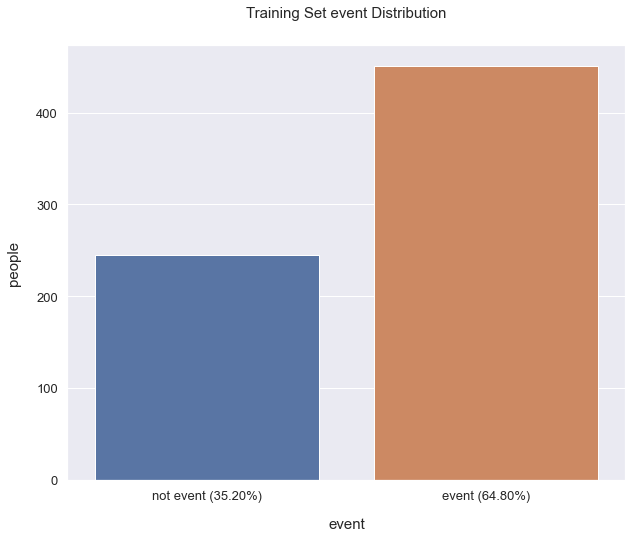

In [1507]:
event = df_train['event'].value_counts()[1]
not_event = df_train['event'].value_counts()[0]

event_per = event / df_train.shape[0] * 100
not_event_per = not_event / df_train.shape[0] * 100

print('{} of {} passengers survived and it is the {:.2f}% of the training set.'.format(event, df_train.shape[0], event_per))
print('{} of {} passengers didnt survive and it is the {:.2f}% of the training set.'.format(not_event, df_train.shape[0], not_event_per))

plt.figure(figsize=(10, 8))
sns.countplot(df_train['event'])

plt.xlabel('event', size=15, labelpad=15)
plt.ylabel('people', size=15, labelpad=15)
plt.xticks((0, 1), ['not event ({0:.2f}%)'.format(not_event_per), 'event ({0:.2f}%)'.format(event_per)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title('Training Set event Distribution', size=15, y=1.05)

plt.show()

In [1508]:
df_train_corr = df_train.drop(['ID'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

df_test_corr = df_test.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)

In [1509]:
corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
df_train_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
8,novator,selfcontrol,0.583043
10,extraversion,selfcontrol,0.508693
12,independ,anxiety,0.416094
14,extraversion,novator,0.283643
16,novator,anxiety,0.270330
18,age,stag,0.217729
20,independ,extraversion,0.214048
22,independ,selfcontrol,0.192205
24,age,extraversion,0.161605
26,anxiety,extraversion,0.143299


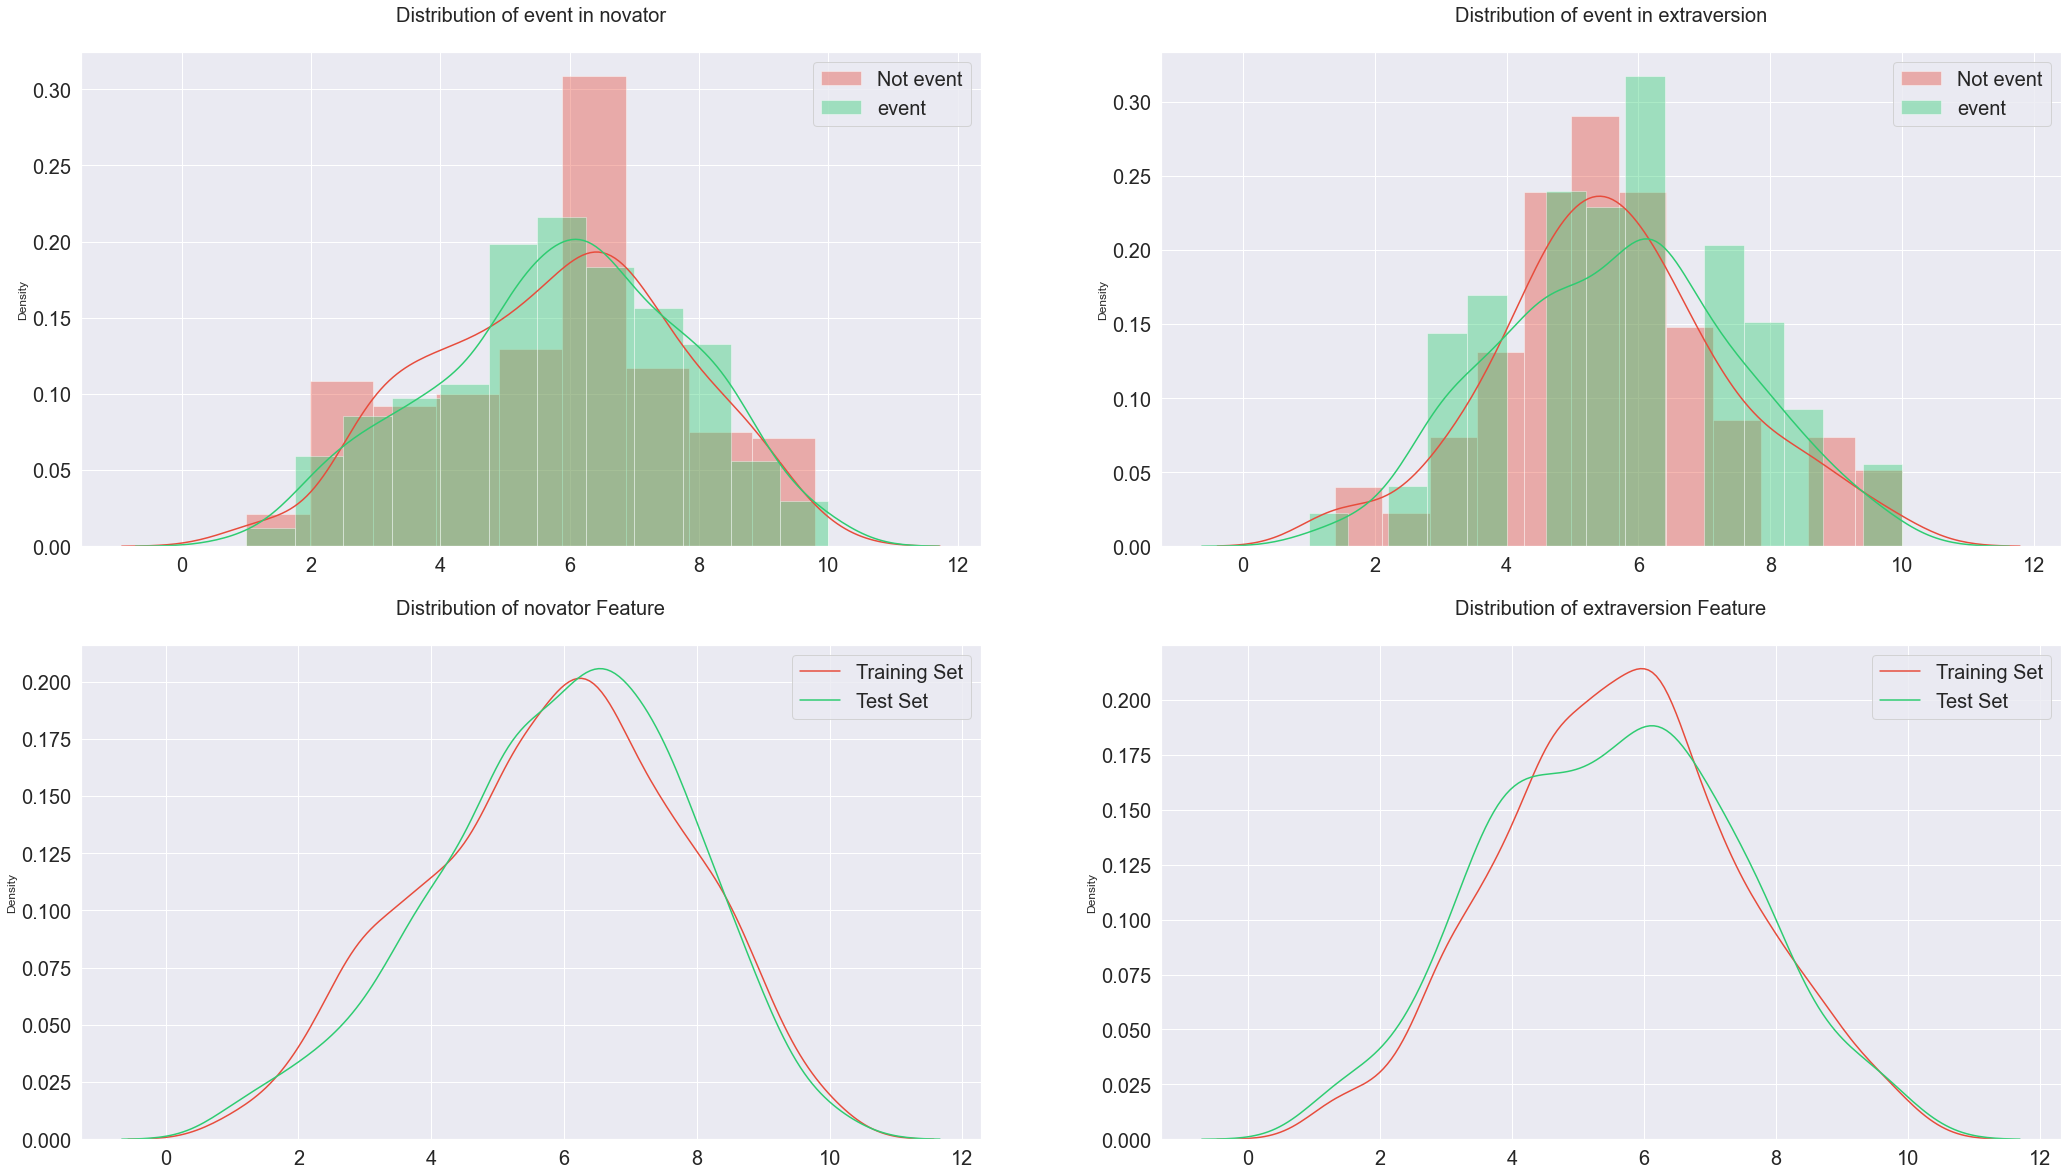

In [1510]:
cont_features = ['novator', 'extraversion']
eventT = df_train['event'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.distplot(df_train[~eventT][feature], label='Not event', hist=True, color='#e74c3c', ax=axs[0][i])
    sns.distplot(df_train[eventT][feature], label='event', hist=True, color='#2ecc71', ax=axs[0][i])
    
    # Distribution of feature in dataset
    sns.distplot(df_train[feature], label='Training Set', hist=False, color='#e74c3c', ax=axs[1][i])
    sns.distplot(df_test[feature], label='Test Set', hist=False, color='#2ecc71', ax=axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of event in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('novator'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('extraversion'), size=20, y=1.05)
        
plt.show()

<AxesSubplot:xlabel='gender', ylabel='age'>

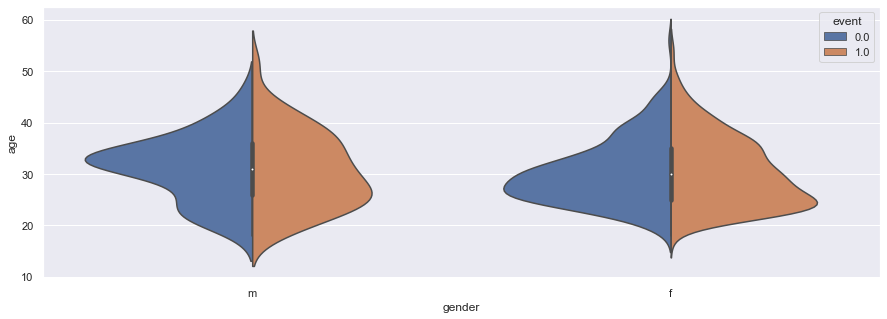

In [1511]:
plt.figure(figsize = (15,5))
sns.violinplot(data = df_all,
              x = 'gender',
              y = 'age',
              hue = 'event',
              split = True)

In [1512]:
y_train = df_train["event"]
X_train = df_train.drop("event", axis=1)
X_test = df_test

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (696, 16)
y_train shape: (696,)
X_test shape: (426, 16)


In [1513]:
X_train.drop("traffic", axis=1, inplace=True)
X_train.drop("head_gender", axis=1, inplace=True)
X_train.drop("way", axis=1, inplace=True)

X_test.drop("traffic", axis=1, inplace=True)
X_test.drop("head_gender", axis=1, inplace=True)
X_test.drop("way", axis=1, inplace=True)

In [1514]:
cat_feature = ["gender", "industry", "profession","coach"]

In [1515]:
for i in cat_feature:
    dummy = pd.get_dummies(df_train[i], prefix=i)
    X_train = pd.concat([X_train, dummy], axis=1)
    X_train.drop(i, axis=1, inplace = True)

In [1516]:
for i in cat_feature:
    dummy = pd.get_dummies(df_test[i], prefix=i)
    X_test = pd.concat([X_test, dummy], axis=1)
    X_test.drop(i, axis=1, inplace = True)

In [1517]:
set(X_train.columns) - set(X_test.columns)

set()

In [1518]:
X_train

,ID,age,anxiety,extraversion,greywage,independ,novator,selfcontrol,stag,gender_f,...,profession_Law,profession_Marketing,profession_PR,profession_Sales,profession_Teaching,profession_etc,profession_manage,coach_my head,coach_no,coach_yes
0,1,35,7.1,6.2,white,4.1,8.3,5.7,7,0,...,0,0,0,0,0,0,0,0,1,0
1,2,33,7.1,6.2,white,4.1,8.3,5.7,22,0,...,0,0,0,0,0,0,0,0,1,0
2,3,35,4.8,6.2,white,6.2,8.3,2.6,15,1,...,0,0,0,0,0,0,0,0,1,0
3,4,35,2.5,5.4,white,7.6,6.7,4.9,15,1,...,0,0,0,0,0,0,0,0,1,0
4,5,32,7.1,3.0,white,4.1,3.7,8.0,8,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,695,31,3.3,6.2,white,6.2,6.7,5.7,14,1,...,0,0,0,0,0,0,0,1,0,0
695,696,23,4.0,6.2,white,4.1,4.4,8.0,33,1,...,0,0,0,0,0,0,0,1,0,0
696,697,31,5.6,1.4,white,7.6,1.0,8.0,70,1,...,0,0,0,0,0,0,0,1,0,0
697,698,22,6.3,8.6,white,2.6,6.7,6.4,39,0,...,0,0,0,0,0,0,0,0,1,0


In [1519]:
y_train.value_counts()

1.0    451
0.0    245
Name: event, dtype: int64

In [1520]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [1538]:
knn_model = KNeighborsClassifier(n_neighbors =30)

In [1526]:
X_train.drop("greywage", axis=1, inplace=True)


In [1555]:
X_test.drop("greywage", axis=1, inplace=True)

In [1527]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 696 entries, 0 to 698
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              696 non-null    int64  
 1   age                             696 non-null    int64  
 2   anxiety                         696 non-null    float64
 3   extraversion                    696 non-null    float64
 4   independ                        696 non-null    float64
 5   novator                         696 non-null    float64
 6   selfcontrol                     696 non-null    float64
 7   stag                            696 non-null    int64  
 8   gender_f                        696 non-null    uint8  
 9   gender_m                        696 non-null    uint8  
 10  industry_ HoReCa                696 non-null    uint8  
 11  industry_Agriculture            696 non-null    uint8  
 12  industry_Banks                  696 

In [1528]:
y_train

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
694    0.0
695    0.0
696    0.0
697    0.0
698    1.0
Name: event, Length: 696, dtype: float64

In [1540]:
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=30)

In [1549]:
result2 = pd.read_csv('머신러닝/data/score.csv')

In [1552]:
y_test = result2['event']

In [1554]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426 entries, 699 to 1128
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              426 non-null    int64  
 1   age                             426 non-null    int64  
 2   anxiety                         426 non-null    float64
 3   extraversion                    426 non-null    float64
 4   greywage                        426 non-null    object 
 5   independ                        426 non-null    float64
 6   novator                         426 non-null    float64
 7   selfcontrol                     426 non-null    float64
 8   stag                            426 non-null    int64  
 9   gender_f                        426 non-null    uint8  
 10  gender_m                        426 non-null    uint8  
 11  industry_ HoReCa                426 non-null    uint8  
 12  industry_Agriculture            4

In [1586]:
pre = knn_model.predict(X_test)

In [1594]:
pre = list(pre)

In [1599]:
pre.append(1)

In [1600]:
len(pre)

431

In [1601]:
pre = np.array(pre)

In [1590]:
y_test

0      1
1      0
2      0
3      0
4      1
      ..
426    0
427    0
428    0
429    0
430    0
Name: event, Length: 431, dtype: int64

In [1602]:
metrics.accuracy_score(y_test, pre)

0.7146171693735499

In [1541]:
result = cross_val_score(knn_model, X_train, y_train, cv= 5)
result

array([0.65      , 0.65467626, 0.22302158, 0.        , 0.35251799])

In [1542]:
result.mean()

0.3760431654676259

In [1605]:
result2['event'] = pre

In [1607]:
result2.to_csv("score22.csv", index = False)